# Feature Analysis


Our end goal in defining and selecting the best feature is to use them to rank stocks in the order of expected furute returns. The more independent predictive the feature we use, the better our ranks and our overall strategy will be.


What we want when comparing features is to make sure the chosen signal is actually predictive of **relative price movements**. We do not want to predict the absolute amount the stocks will move up or down. We only care that stocks ranked higher go up more than stocks ranked lower. If our ranking derived from our feature is predictive, this means that stocks at the top will tend to outperform stocks at the bottom. As long this spread (top stocks returns - bottom stock returns) is consistent over time our strategy will have a positive return. 


Let's have a look at a feature and try to assess its viability. 

First run the code below to set up.

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
### Load the Data
### THIS STEP WILL TAKE A WHILE TO RUN the first time
from backtester.dataSource.csv_data_source import CsvDataSource
from datetime import datetime

startDateStr='2010/06/02'
endDateStr='2013/02/07'
cachedFolderName='historicalData/'
dataSetId='QQ3Data'
ds = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId='QQ3Data',
                             instrumentIds=[],
                             downloadUrl = 'https://raw.githubusercontent.com/Auquan/qq3Data/master',
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr='2010/06/02',
                             endDateStr='2013/02/07',
                             liveUpdates=False,
                             pad=True)

Processing data for stock: SIZ
Processing data for stock: MLQ
Processing data for stock: MAI
Processing data for stock: PVV
Processing data for stock: IPV
Processing data for stock: DHP
Processing data for stock: EKA
Processing data for stock: WTX
Processing data for stock: EYC
Processing data for stock: YSB
Processing data for stock: SEP
Processing data for stock: INS
Processing data for stock: IIZ
Processing data for stock: DFY
Processing data for stock: OAX
Processing data for stock: HIS
Processing data for stock: QZO
Processing data for stock: ZSB
Processing data for stock: SXH
Processing data for stock: CUY
Processing data for stock: GYQ
Processing data for stock: ARD
Processing data for stock: YCY
Processing data for stock: FXQ
Processing data for stock: CJV
Processing data for stock: OJF
Processing data for stock: DDV
Processing data for stock: EEN
Processing data for stock: SSD
Processing data for stock: FWX
Processing data for stock: AWU
Processing data for stock: ONS
Processi

In [4]:
# Load Relevant information
price = 'F5'
returns = 'F2'
# data = ds.getBookDataByFeature()[price]
# returns a list of instrument identifiers
ids = ds.getInstrumentIds()
print("Available Instruments are:")
print(ids)

# returns a list of feature keys which are already present in the data.
featureKeys = ds.getBookDataFeatures()
print("Available Features are:")
print(featureKeys)

## Load relevant prices in a dataframe
DataDictByInstrument = ds.emitAllInstrumentUpdates()

Available Instruments are:
['SIZ', 'MLQ', 'MAI', 'PVV', 'IPV', 'DHP', 'EKA', 'WTX', 'EYC', 'YSB', 'SEP', 'INS', 'IIZ', 'DFY', 'OAX', 'HIS', 'QZO', 'ZSB', 'SXH', 'CUY', 'GYQ', 'ARD', 'YCY', 'FXQ', 'CJV', 'OJF', 'DDV', 'EEN', 'SSD', 'FWX', 'AWU', 'ONS', 'KEH', 'ZHU', 'HNM', 'LTN', 'ZKF', 'SJB', 'WCJ', 'JBP', 'EGP', 'FVA', 'JHB', 'AKK', 'QON', 'URZ', 'CAW', 'OSF', 'TDW', 'KMY', 'ATN', 'MLP', 'EMD', 'AGM', 'QCE', 'HRY', 'BPM', 'MPC', 'DIZ', 'GWI', 'FVB', 'DZU', 'GQX', 'WMN', 'ENQ', 'DJV', 'WBM', 'ORH', 'YAE', 'BYZ', 'YXP', 'SLM', 'NMS', 'WJP', 'DGT', 'KCN', 'WWV', 'GOR', 'ZMP', 'QCM', 'VML', 'XZC', 'AJM', 'NLF', 'NTG', 'NSN', 'CSI', 'PES', 'OIL', 'SJL', 'ZFC', 'BST', 'DLL', 'AAE', 'OLY', 'VIC', 'QZU', 'DOE', 'GUY', 'BBA', 'YSL', 'ZGR', 'AGG', 'AQM', 'LUY', 'SNF', 'UNB', 'ZRN', 'VSV', 'SSL', 'VUV', 'ZQY', 'RCL', 'EXR', 'BYB']
Available Features are:
['F0', 'F1', 'F2', 'F3', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22

In [15]:
## Load Prices
prices = pd.DataFrame(columns=ids)
for i in ids:
    prices[i] = DataDictByInstrument[i][price]

### Simple Ratio 

Let's say that we suspect that a simple feature which is a ratio of two features could potentially be predictive of relative stock returns. 

### STEP 0: Create a Feature to be used to rank stocks

In [94]:
## Calculate Ranking Feature

feature = pd.DataFrame(columns=ids)
for i in ids:
    f1 = DataDictByInstrument[i]['F45']
    f2 = DataDictByInstrument[i]['F34']
    feature[i] = f1/f2

Now let's analyze how good this feature is.

## Returns Analysis


First we calculate our forward returns. The forward returns are the returns that we would have received for holding each stock over the day periods ending on the given date, passed in through the `periods` parameter. In our case, and by default, we look $1$ day in advance. 

**1. Let's first create $n$ day forward returns. To do this, we calculate returns and shift it back by $n$ **

In [95]:
period = 1
returns = prices/prices.shift(period*75)-1
forward_returns = returns.shift(-period*75)

**2. Next, let's rank our stocks by feature, i.e. for every stock, where does it's feature value rank relative to other stocks**

In [96]:
ranks = feature.rank(axis=1)

While we want an accurate ranking, we mostly care if we have the right stocks at the top and at the bottom. To do this, we create basket of stocks, with $basketSize$ stocks in each basket. Now we only care about the feature insofar as it relates to movement of stocks into and out of the top and bottom baskets. 
Hence we separate our feature into baskets for each date, replacing the feature value with its appropriate basket on a given day. 

In [97]:
basket_size = 10
baskets = (ranks/basket_size).apply(np.floor)

**3. Now we can take the feature baskets and calculate the mean returns for each basket over the given time stamps**

In [98]:
basket_returns = pd.DataFrame(columns=range(1,12))
for i in range(1,12):
    basket_returns[i] = forward_returns[baskets==i].mean(axis=1)
    

**4. Also look at averaged returns for each basket over the entire time for each period.**

In [99]:
basket_returns.mean()

1     0.001270
2     0.001028
3     0.001121
4     0.001026
5     0.000999
6     0.000917
7     0.001037
8     0.001107
9     0.001123
10    0.000671
11    0.000329
dtype: float64



**5. Now try plotting a bar chart of mean returns by feature quantile.**

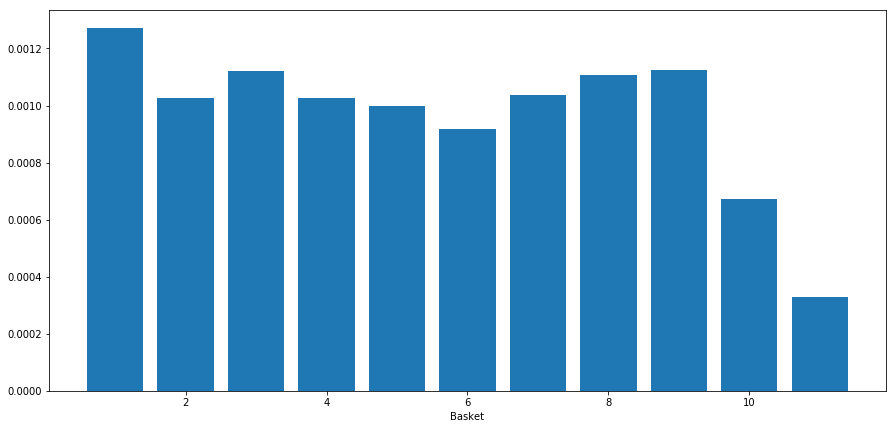

In [100]:
plt.figure(figsize=(15,7))
plt.bar(range(1,12), basket_returns.mean())
plt.xlabel('Basket')
plt.show()


**6. Now calculate the returns spread, based on subtracting the mean return of the lowest basket from the mean return of the highest basket (simulating going short on the lowest and long on the highest) for all days for different forward returns. **

In [101]:
returns_spread = basket_returns[1] - basket_returns[11]
returns_spread.mean()

0.0009410052359687084

**7. Try plotting this time series of spread.**

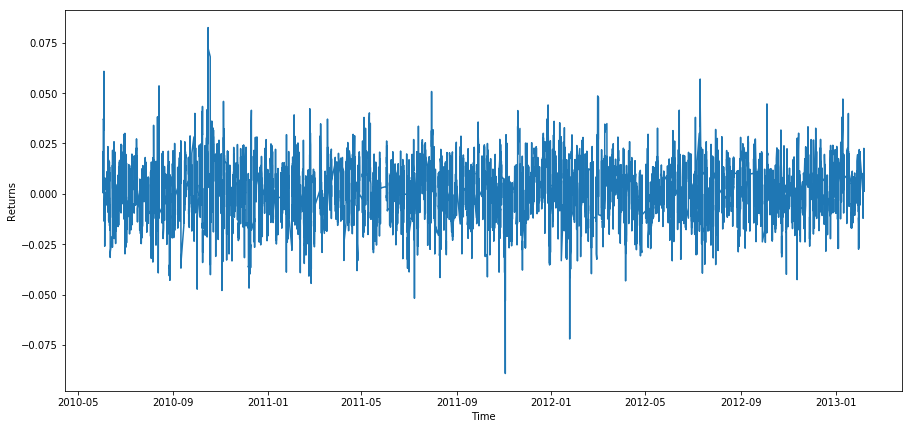

In [102]:
plt.figure(figsize=(15,7))
plt.plot(returns_spread)
plt.ylabel('Returns')
plt.xlabel('Time')

plt.show()

**8. Now aggregate the returns of each individual quantile into a plot of cumulative returns separated by basket for the 1-period forward returns. **
What we want here is to see discrete "fingers" with few to no crossovers. This will give us an idea of which baskets tend to drive the returns (ideally the first and last).

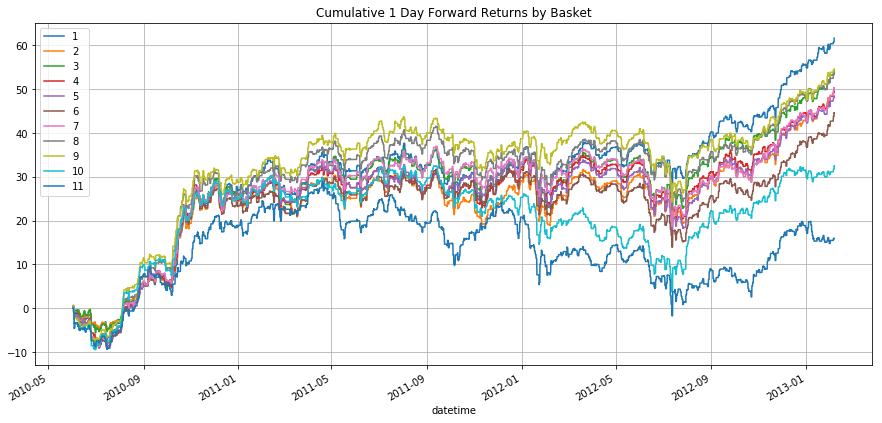

In [103]:
basket_returns.cumsum(axis=0).plot(figsize=(15,7), title='Cumulative 1 Day Forward Returns by Basket',
                                   grid=True, legend=True, )

**9. Also plot the cumulative feature-weighted returns in a long-short portfolio. This shows the performance of the feature as a whole, which is always important to consider. A long-short portfolio will only involve the first and last basket.**

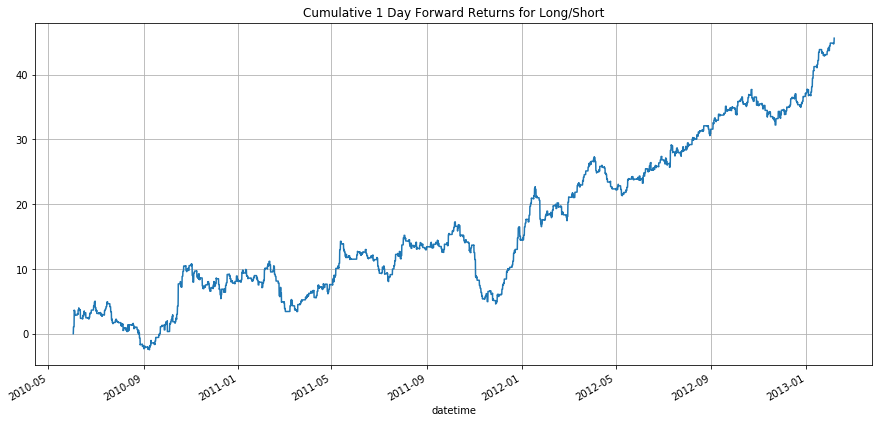

In [104]:
returns_spread.cumsum(axis=0).plot(figsize=(15,7), title='Cumulative 1 Day Forward Returns for Long/Short',
                                   grid=True, legend=False )

By this point, you know what we are trying to do! We want to create a feature that ranks our stocks as accurately as possible so that we can maximize the difference between returns of first and last basket (we calculate this in **step 6**. We also want to make this difference has low variance (we do a visual check in **step 7**), top and bottom baskets to drive the returns (visual check in **step 8**) and consistent returns with low drawdowns (visual check in **step 9**).
This analysis should give you a good idea if your feature ranks your stocks well. Let's now see your score based on the feature.

## Correlation Analysis

We use the information coefficient (IC) to assess the predictive power of a feature. The IC of a feature is its Spearman Rank Correlation. To break it down, we calculate the IC between the feature values and the forward returns. The IC assesses the monotonic relationship between features and returns. What this means, intuitively, is that it provides a measure for whether higher feature values can be associated with higher relative returns. A higher IC indicates that higher feature values are more closely associated with higher return values (and lower feature values with lower return values). A very negative IC indicates that higher feature values are closely associated with lower return values. An IC of $0$ indicates no relationship.

**10. You can calculate IC as the Spearman Rank Correlation between forward returns and feature values of all stocks for everyday**

In [105]:
correl_scores = forward_returns.corrwith(feature, axis=1, drop=True)

correl_scores.dropna(inplace = True)    

In [106]:
print('Mean Correlation: %.3f, Standard Deviation: %.3f'%(correl_scores.mean(), correl_scores.std()))

Mean Correlation: -0.013, Standard Deviation: 0.129


**13. Now plot the IC as a time series for each period along with a 1-month moving average to smooth it out. What we want here is consistency over time and a consistently informative signal.**

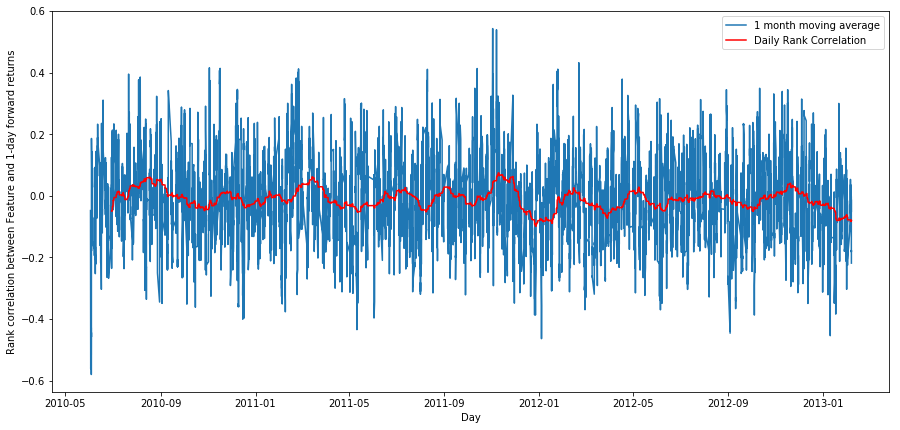

In [107]:
plt.figure(figsize=(15,7))
plt.plot(correl_scores)
plt.plot(correl_scores.rolling(20*75).mean(), 'r-')
plt.xlabel('Day')
plt.legend(['1 month moving average', 'Daily Rank Correlation'])
plt.ylabel('Rank correlation between Feature and %s-day forward returns'%period);
plt.show()

What do you think? What we want here is a Feature that has high correlation with forward returns, consistency over time and a consistently informative signal. IF you are happy with your feature, you can now move to the problem3_template.py file, otherwise go back and try some more features.
**Implement the feature you created in STEP 0 in problem3_template.py**

## Further Analysis

To Further analyze your feature, you can also do the following. 
#### For the rest of this sheet, we are giving you helper instructions, but you have to write the code yourself.  The plots/dataframes are suggestions on what your plots could look like, they don't have to match.

Hopefully, you've accumulated enough python knowledge so far and this should be easy. Feel free to ask questions on discord if needed.:

**14. Histograms are good to show us the distribution of the IC. These will clearly show any strange outliers and how they affect the overall curve.**

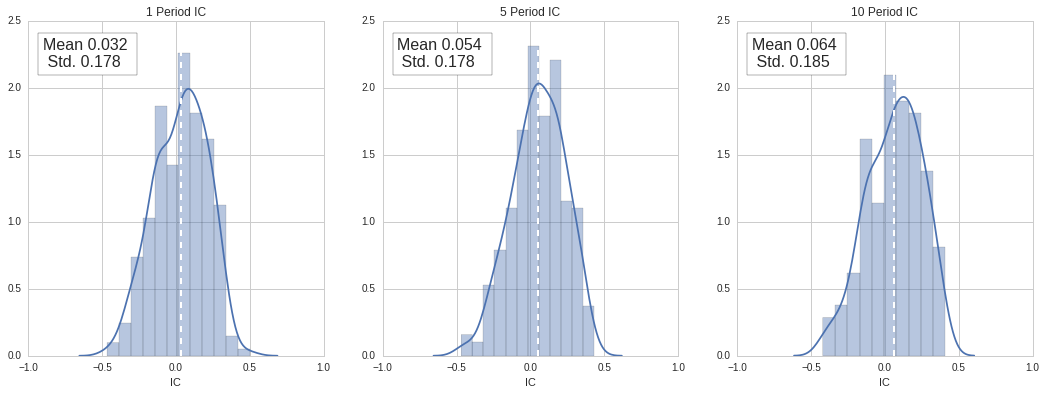

A QQ-plot compares the distribution of the IC to the normal distribution. It plots the quantiles of one distribution against the quantiles of the other, typically with a reference line at $y = x$. If the points in the QQ-plot fall entirely along this line, this indicates that the two distributions are the same. In practice, a QQ-plot serves as a measure of similarity between distributions. Generally, what we want to see here is an S-shaped curve. This indicates that the tails of the IC distribution are fatter and contain more information.

**15. Plot the qq plots of your IC for different periods**

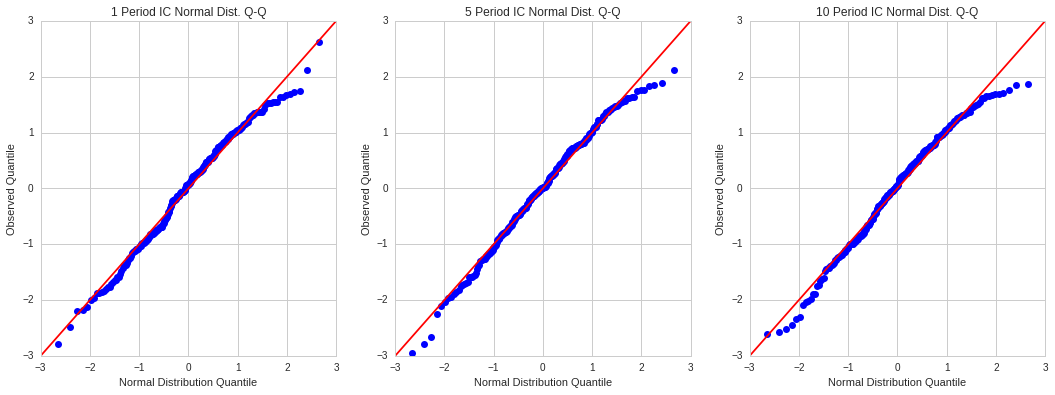

## Turnover

When considering the impact of actually implementing this fearure as a signal in a strategy, turnover is a critical thing to consider. This plot shows the turnover of the top and bottom quantiles of your feature, the baskets that you would actually be trading on with a long-short approach. Excessive turnover will eat away at the profits of your strategy through commission costs. Sometimes a signal just isn't good enough to fight against the tide on the scale that you have to deal with through your broker.
You can calculate turnover for a quantile as the proportion of names new to that quantile over any period. For example, for 5 day period, if your lowest quantile basket changes from [A,B,C,D,E] to [A,B,F,D,G], the turnover is 40%

**16. Try plotting the turnover time series for different periods.**

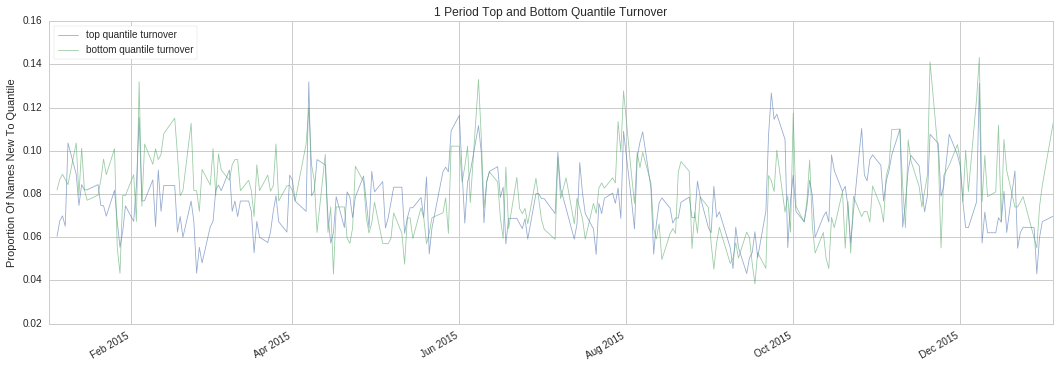

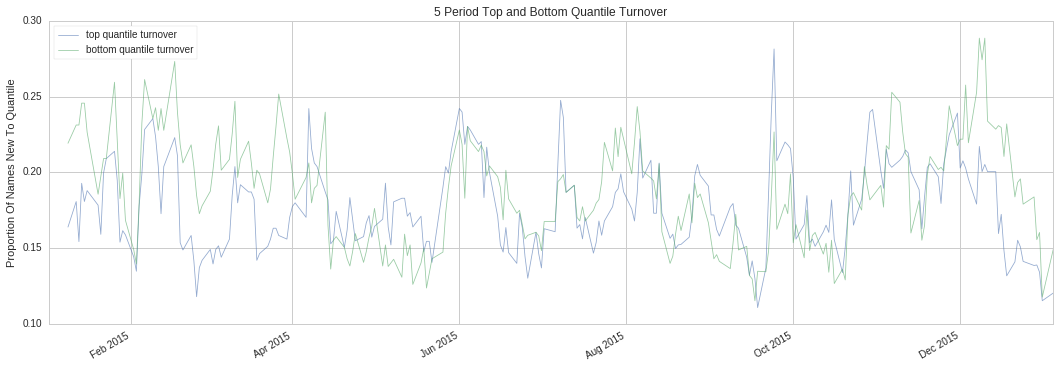

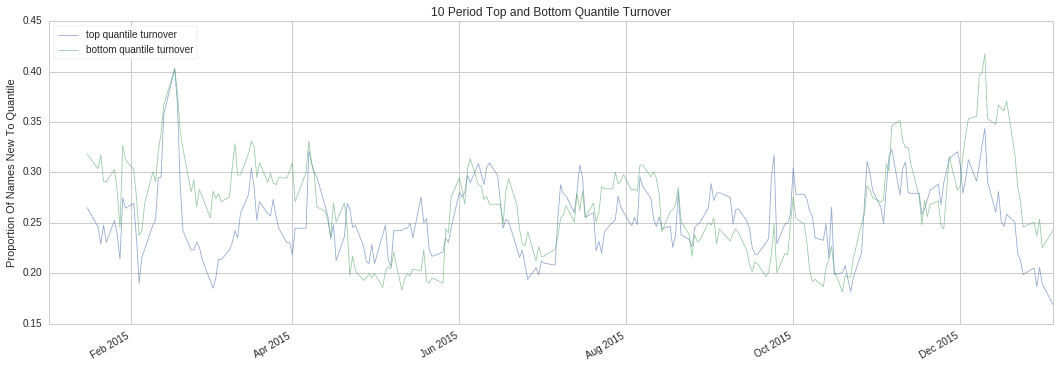

We want a low turnover for the feature, implying that we will not be hit too hard by the constant changing of portfolio positions. We cannot see the costs directly in this analysis, only metrics that we can use to judge a feature by itself. To properly model undermining influences such as slippage and commissions you will need to implement a strategy that uses your feature in the backtester.

### Autocorrelation

feature autocorrelation is the measure of correlation between the current value of the feature and its previous value. The idea behind its calculation is to provide another measure of the turnover of the feature quantiles. If the autocorrelation is low, it implies that the current value of the feature has little to do with the previous value and that portfolio positions are changing frequently from time period to time period. If the next value of the feature is significantly influenced by its last value, this means that your ranking scheme is more consistent (though this has no influence on its ability to forecast relative price movements).

**17. Calculate the autocorrelation for your chosen feature and plot it over time.**

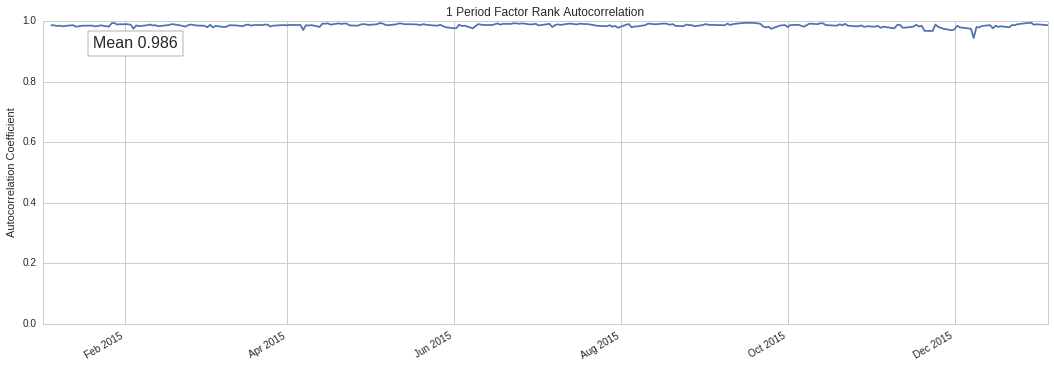

Autocorrelation should also corroborate the turnover plots from above (high autocorrelation will suggest more consistent portfolio positions)